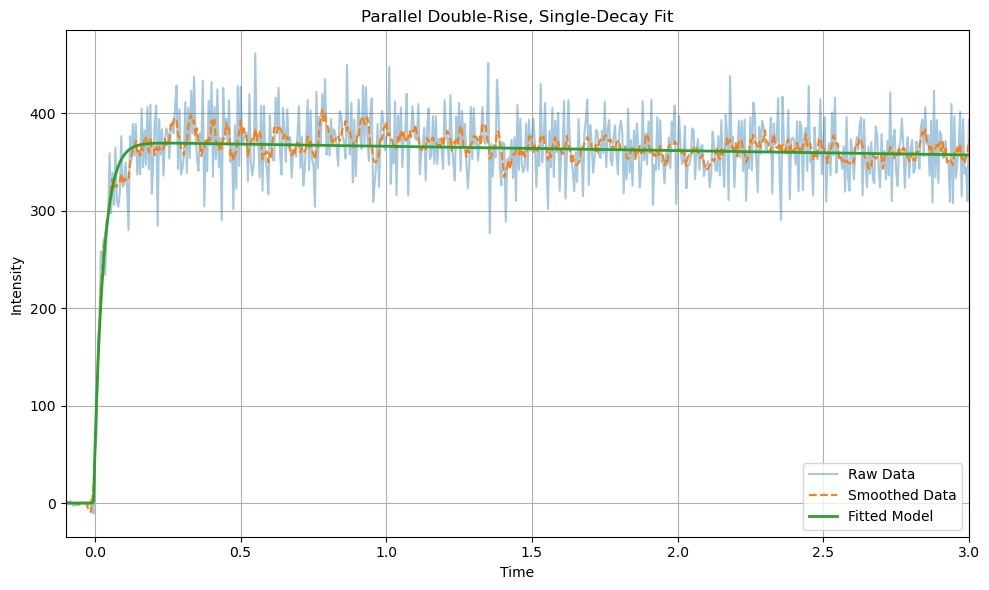

{'y0': -377.40690552346507,
 'A1': 370.71366581936735,
 'tau_r1': 0.03137381461510529,
 'A2': 1.220362332109883e-10,
 'tau_r2': 0.7999969761097302,
 'A3': 377.3885010220318,
 'tau_d': 83.03200002888319,
 't0': -0.0051998899710170065}

In [5]:
# Re-import required packages after code execution environment reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# Re-load data
file_path = r"C:\Users\Jacob\Downloads\Data_60K.txt"
raw_data = pd.read_csv(file_path, sep="\t", skiprows=1, header=None, names=["Intensity", "Time"])

# Sort by time
raw_data = raw_data.sort_values("Time")

# Extract arrays
t = raw_data["Time"].values
y = raw_data["Intensity"].values

# Smooth the data slightly
y_smoothed = savgol_filter(y, window_length=11, polyorder=2)

# Define the parallel double-rise, single-decay model
def parallel_double_rise_decay(t, y0, A1, tau_r1, A2, tau_r2, A3, tau_d, t0):
    t_shifted = t - t0
    t_shifted[t_shifted < 0] = 0
    rise1 = A1 * (1 - np.exp(-t_shifted / tau_r1))
    rise2 = A2 * (1 - np.exp(-t_shifted / tau_r2))
    decay = A3 * np.exp(-t_shifted / tau_d)
    return y0 + rise1 + rise2 + decay


# Initial guess and bounds
#["y0", "A1", "tau_r1", "A2", "tau_r2", "A3", "tau_d", "t0"]
p0 = [0, 1, 0.004, 0.000001, 0.5, 100, 83.033, 0]
bounds = (
    [-np.inf,  .1,  .00050,  .0000000001,  .1,  .1,    83.032,   -1],
    [np.inf,   10000,  .05,   0.00001,  .8,  1000000, 83.034,   1]
)

# Fit the model
params_opt, _ = curve_fit(parallel_double_rise_decay, t, y, p0=p0, bounds=bounds)

# Generate fitted curve
y_fit = parallel_double_rise_decay(t, *params_opt)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Raw Data', alpha=0.4)
plt.plot(t, y_smoothed, label='Smoothed Data', linestyle='--')
plt.plot(t, y_fit, label='Fitted Model', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.xlim(-0.1, 3)
plt.title("Parallel Double-Rise, Single-Decay Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compute fitted curve
y_fit = parallel_double_rise_decay(t, *params_opt)


# Save fit data to a CSV
fit_output = pd.DataFrame({
    "Time": t,
    "Raw_Data": y,
    "Smoothed_Data": y_smoothed,
    "Fitted_Model": y_fit
})
fit_output_path = r"C:\Users\Jacob\Downloads\fitted_data.csv"
fit_output.to_csv(fit_output_path, index=False)

# Print fitted parameters
param_names = ["y0", "A1", "tau_r1", "A2", "tau_r2", "A3", "tau_d", "t0"]
fitted_params = dict(zip(param_names, params_opt))
fitted_params

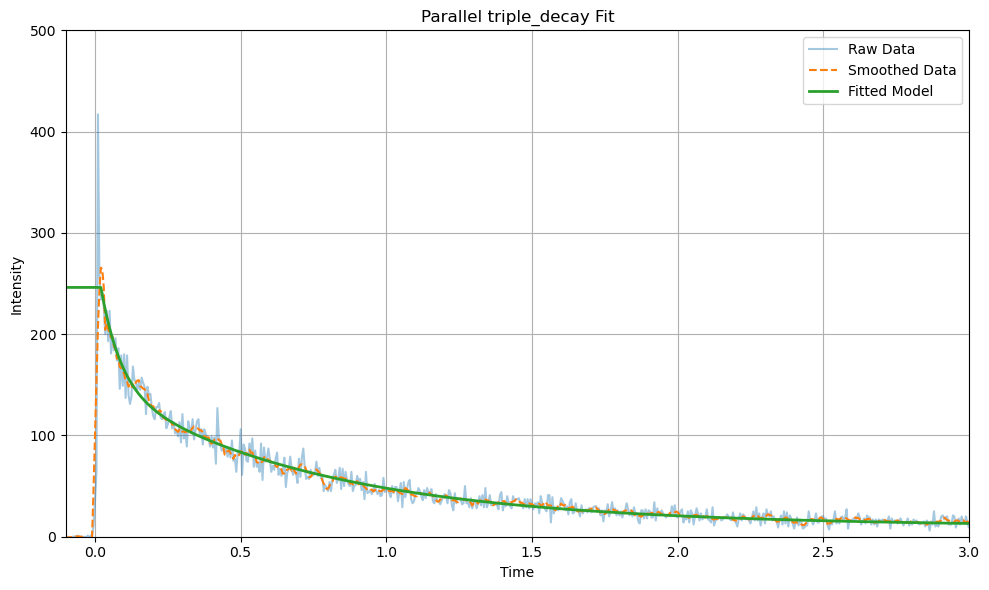

Fitted parameters: {'y0': 0.18802234770989018, 'A1': 96.45473119381488, 'tau_d1': 0.06674990698379762, 'A2': 135.40373825507527, 'tau_d2': 0.7218358489360523, 'A3': 14.105066142365581, 'tau_d3': 10.857704584747994, 't0': 0.020212177239910204}


In [54]:
# Re-import required packages after code execution environment reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# -------- user control: how many points to skip after t >= 0 --------
skip_npoints = 5  # e.g., 2 to skip t=0 and the next point

# Re-load data
file_path = r"C:\Users\Jacob\Downloads\data_1200nm_doped_tripledecay.txt"
raw_data = pd.read_csv(file_path, sep="\t", skiprows=1, header=None, names=["Intensity", "Time"])

# Sort by time
raw_data = raw_data.sort_values("Time")

# Extract arrays
t = raw_data["Time"].values
y = raw_data["Intensity"].values

# Smooth the data slightly
y_smoothed = savgol_filter(y, window_length=11, polyorder=2)

# Define the parallel triple_decay model
def parallel_triple_decay(t, y0, A1, tau_d1, A2, tau_d2, A3, tau_d3, t0):
    t_shifted = t - t0
    t_shifted = np.where(t_shifted < 0, 0.0, t_shifted)
    decay1 = A1 * np.exp(-t_shifted / tau_d1)
    decay2 = A2 * np.exp(-t_shifted / tau_d2)
    decay3 = A3 * np.exp(-t_shifted / tau_d3)
    return y0 + decay1 + decay2 + decay3

# Initial guess and bounds
# ["y0", "A1", "tau_d1", "A2", "tau_d2", "A3", "tau_d3", "t0"]
p0 = [0, 9000, 0.05, 250, 0.5, 100, 10, 1]
bounds = (
    [-np.inf,  1e-4,  .01,  1e-4,  .2,  1e-4,   1,  -np.inf],
    [ np.inf,  1e5,   .08,  1e5,   .8,  1e5,  20,   np.inf]
)

# -------- build fit subset by skipping N points after t >= 0 --------
idx0 = np.searchsorted(t, 0.0, side='left')  # first index with t >= 0
start = idx0 + int(skip_npoints)
if start >= len(t) - 8:
    raise ValueError("Too few points left to fit after skipping. Reduce skip_npoints.")

t_fit_data = t[start:]
y_fit_data = y_smoothed[start:]

# Fit the model on the selected region
params_opt, _ = curve_fit(parallel_triple_decay, t_fit_data, y_fit_data, p0=p0, bounds=bounds)

# Generate fitted curve over the FULL time axis (for plotting/output)
y_fit = parallel_triple_decay(t, *params_opt)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Raw Data', alpha=0.4)
plt.plot(t, y_smoothed, label='Smoothed Data', linestyle='--')
plt.plot(t, y_fit, label='Fitted Model', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.xlim(-0.1, 3)
plt.ylim(0, 500)
plt.title("Parallel triple_decay Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save fit data to a CSV
fit_output = pd.DataFrame({
    "Time": t,
    "Raw_Data": y,
    "Smoothed_Data": y_smoothed,
    "Fitted_Model": y_fit
})
fit_output_path = r"C:\Users\Jacob\Downloads\fitted_data.csv"
fit_output.to_csv(fit_output_path, index=False)

# Print fitted parameters as a dict
param_names = ["y0", "A1", "tau_d1", "A2", "tau_d2", "A3", "tau_d3", "t0"]
fitted_params = dict(zip(param_names, params_opt))
print("Fitted parameters:", {k: float(v) for k, v in fitted_params.items()})
